## Tutorial 2. Multi-level attention RNN

Written by Sundong Kim (sundong.kim@kaist.ac.kr), Nov 23rd, 2018,

In this tutorial, we introduce how to use multi-level attention RNN with indoor mobility datasets.

* First, we train embeddings of areas.
* Seconds, we put our trajectories into multi-level attention RNN network.
* Third, we generate basic statistical features from each visit.
    * total dwell time
    * the number of area
    * the number of unique areas
* Fourth, we perform binary classification to predict customer revisit intention.

Source: https://jusonn.github.io/blog/2018/04/24/gensim-word2vec-embedding/

In [1]:
import pandas as pd
import numpy as np
import os
import random

# In this tutorial, we will use a store_A dataset.
pre_release_path = '../data_sample/indoor/store_A/'

In [2]:
# Load dataset

train_labels = pd.read_csv(pre_release_path+'train_labels.tsv', sep='\t')
test_labels = pd.read_csv(pre_release_path+'test_labels.tsv', sep='\t')
train_visits = pd.read_csv(pre_release_path+'train_visits.tsv', sep='\t')
test_visits = pd.read_csv(pre_release_path+'test_visits.tsv', sep='\t')
wifi_sessions = pd.read_csv(pre_release_path+'wifi_sessions.tsv', sep='\t')

### 1. Exploring dataset

In [3]:
train_labels.head(5)

,visit_id,revisit_interval,revisit_intention
0,v115,96.76,1
1,v116,21.00,1
2,v117,7.88,1
3,v118,20.86,1
4,v119,12.98,1


In [4]:
train_visits.head(5)

,visit_id,wifi_id,date,indices
0,v115,135,17174,42065;42066;42081;42087;42112;42139
1,v116,135,17271,397687;397688;397706;397711;397786;397966;3982...
2,v117,135,17292,439218;439219;439227;439311;439391;439469;4398...
3,v118,135,17300,450465;450495;450496;450497;451056
4,v119,135,17321,490298;490310;490349;490446;490557;490752;490870


In [5]:
test_labels.head(5)

,visit_id,revisit_interval,revisit_intention
0,v42703,10.85,1
1,v43041,NaN,0
2,v43172,NaN,0
3,v43241,6.12,1
4,v43258,5.02,1


In [6]:
test_visits.head(5)

,visit_id,wifi_id,date,indices
0,v42703,135,17352,547542;547543;547544;547901;547903;548351;548624
1,v43041,956,17358,560400;560401;560407;560409;560410;560704;5607...
2,v43172,1265,17383,611470;611471;611479;611482;611524
3,v43241,1440,17354,551658;551659;551660;551662;551665;551666;5516...
4,v43258,1482,17378,599972;599973;599976


In [7]:
wifi_sessions.head(5)

,index,wifi_id,ts,area,dwell_time
0,94,45809,1483239094,out,35
1,929,4108,1483242690,out,529
2,1319,45809,1483243908,out,1203
3,1366,45809,1483244037,in,1058
4,1367,45809,1483244037,1f,1058


**Some statistics**

In [8]:
# Number of unique users

print(len(train_labels),len(train_visits),len(test_labels),len(test_visits),len(wifi_sessions))

427 427 242 242 7913


In [9]:
# Number of unique users

len(set(train_visits.wifi_id)), len(set(test_visits.wifi_id)) 

(329, 242)

In [10]:
# Revisit ratio

print(train_labels.revisit_intention.value_counts())
print()
print(test_labels.revisit_intention.value_counts())

0    258
1    169
Name: revisit_intention, dtype: int64

0    186
1     56
Name: revisit_intention, dtype: int64


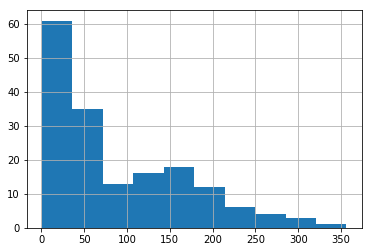

In [11]:
# Revisit interval - train data - among users who revisit
%matplotlib inline
train_labels.revisit_interval.hist()

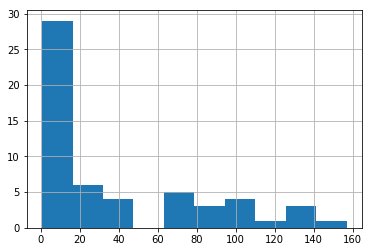

In [12]:
# Revisit interval - test data - among users who revisit
test_labels.revisit_interval.hist()

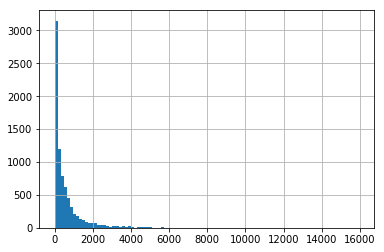

In [13]:
# Wifi session logs distribution by dwell_time
wifi_sessions.dwell_time.hist(bins=100)

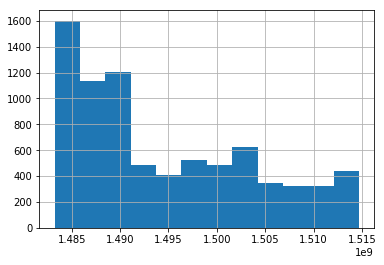

In [14]:
# Wifi session logs distribution by each month:
#  - The number of logs from train period is larger than the number of logs from test period.
#  - Since we only retain one indoor visit for each wifi-id in the test period.
wifi_sessions.ts.hist(bins=12)

In [15]:
# Wifi session logs distribution by area
wifi_sessions.area.value_counts()

out        1615
1f          871
in          779
1f-d        602
1f-c        563
b1          545
b1_only     516
1f-e        437
1f-f        414
cafe        371
b1-a        289
b1-b        271
2f          175
b1-c        164
2f-e         84
2f-c         77
2f-a         55
2f-d         48
2f-b         37
Name: area, dtype: int64

### 2. Area Embedding

In [16]:
train_visits.head(3)

,visit_id,wifi_id,date,indices
0,v115,135,17174,42065;42066;42081;42087;42112;42139
1,v116,135,17271,397687;397688;397706;397711;397786;397966;3982...
2,v117,135,17292,439218;439219;439227;439311;439391;439469;4398...


In [17]:
dict_index_area = {i:j for i,j in zip(wifi_sessions['index'],wifi_sessions['area'])}
dict_index_dwelltime = {i:j for i,j in zip(wifi_sessions['index'], wifi_sessions['dwell_time'])}

In [18]:
test_visits.tail(3)

,visit_id,wifi_id,date,indices
239,v67497,98096,17397,644995;644996;645002;645003;645019;645021;6452...
240,v67538,98274,17495,851373;851374;851375;851440;851553;851561;8515...
241,v67691,98936,17475,813681;813682;813683;813692;813727;813779;8137...


In [19]:
### Before feature engineering, querying some useful information from wifi-sessions data, and add to the dataframe.
### This method is much faster than the same add_infos method from tutorial 1.

def add_infos(df):
    df['l_index'] = df['indices'].apply(lambda x: [int(x) for x in x.split(';')])
    df['dwell_times'] = df['l_index'].apply(lambda x: [dict_index_dwelltime[idx] for idx in x])
    df['areas'] = df['l_index'].apply(lambda x: [dict_index_area[idx] for idx in x])
    return df

In [20]:
train_visits = add_infos(train_visits)
test_visits = add_infos(test_visits)

In [21]:
train_visits.head(3)

,visit_id,wifi_id,date,indices,l_index,dwell_times,areas
0,v115,135,17174,42065;42066;42081;42087;42112;42139,"[42065, 42066, 42081, 42087, 42112, 42139]","[635, 635, 252, 156, 17, 11]","[1f, in, b1, b1_only, cafe, 1f-e]"
1,v116,135,17271,397687;397688;397706;397711;397786;397966;3982...,"[397687, 397688, 397706, 397711, 397786, 39796...","[9559, 39, 9156, 129, 871, 1317, 50, 153, 1483...","[in, 1f, b1, cafe, cafe, cafe, cafe, cafe, caf..."
2,v117,135,17292,439218;439219;439227;439311;439391;439469;4398...,"[439218, 439219, 439227, 439311, 439391, 43946...","[12065, 778, 11709, 400, 9715, 840, 247, 256, ...","[in, 1f, b1, cafe, cafe, b1_only, b1_only, b1_..."


In [22]:
test_visits.tail(3)

,visit_id,wifi_id,date,indices,l_index,dwell_times,areas
239,v67497,98096,17397,644995;644996;645002;645003;645019;645021;6452...,"[644995, 644996, 645002, 645003, 645019, 64502...","[225, 2617, 101, 125, 1958, 1815, 237, 71, 39]","[1f, in, 1f-c, 1f-d, b1, cafe, 1f, 1f-c, 1f-d]"
240,v67538,98274,17495,851373;851374;851375;851440;851553;851561;8515...,"[851373, 851374, 851375, 851440, 851553, 85156...","[5101, 3398, 3034, 680, 870, 458, 727, 568, 36]","[in, b1, cafe, b1_only, b1_only, b1-c, b1-a, 1..."
241,v67691,98936,17475,813681;813682;813683;813692;813727;813779;8137...,"[813681, 813682, 813683, 813692, 813727, 81377...","[2174, 192, 706, 312, 10, 457, 456, 746, 490]","[in, 1f-e, 1f, 1f-d, 1f-f, b1, b1_only, 1f, 1f-f]"


#### Gensim - area embedding using word2vec

In [23]:
import gensim
import scipy
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# gensim.utils.simple_preprocess(list(train_visits['areas']))

model = gensim.models.Word2Vec(list(train_visits['areas']), size=5, min_count=7)

In [25]:
scipy.spatial.distance.cosine(model.wv.get_vector('b1_only'), model.wv.get_vector('2f-e'))

0.016818583011627197

In [26]:
model.wv.most_similar(positive=['2f-e','b1_only'])

[('2f-d', 0.999172568321228),
 ('1f-e', 0.9984712600708008),
 ('b1', 0.9976984262466431),
 ('cafe', 0.9975658655166626),
 ('2f', 0.9970953464508057),
 ('b1-c', 0.9955246448516846),
 ('in', 0.9947461485862732),
 ('1f-c', 0.9943808317184448),
 ('1f', 0.9938952922821045),
 ('1f-d', 0.9932493567466736)]

In [27]:
model.wv.most_similar('2f-e')

[('1f-c', 0.9955536723136902),
 ('b1', 0.9954655766487122),
 ('1f-e', 0.9940140843391418),
 ('2f', 0.9926421046257019),
 ('cafe', 0.9925605058670044),
 ('2f-d', 0.9920715689659119),
 ('1f', 0.9910839200019836),
 ('b1-c', 0.9905915260314941),
 ('b1-a', 0.9902745485305786),
 ('in', 0.9896036386489868)]

In [28]:
from sklearn import manifold

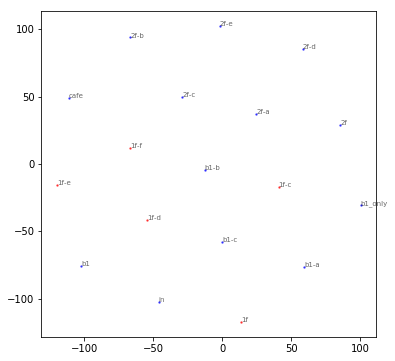

In [29]:
### Visualize area vector


# viz_words = 30
# word_vector = np.concatenate((model.wv.vectors[:viz_words//2,:], model.wv.vectors[11489:11489+viz_words//2,:]), axis=0)

viz_words = len(model.wv.vectors)
word_vector = model.wv.vectors


tsne = sklearn.manifold.TSNE(n_components=2)
embed_tsne = tsne.fit_transform(word_vector)

fig, ax = plt.subplots(figsize=(6,6))
for i in range(viz_words):
    if model.wv.index2word[i][:2] == '1f':
        plt.scatter(*embed_tsne[i,:],s=2,alpha=0.6, color='r')
        plt.annotate(model.wv.index2word[i], (embed_tsne[i,0], embed_tsne[i,1]), alpha=0.6, fontsize=7)
    else:
        plt.scatter(*embed_tsne[i,:],s=2,alpha=0.6,color='b')
        plt.annotate(model.wv.index2word[i], (embed_tsne[i,0], embed_tsne[i,1]), alpha=0.6, fontsize=7)
# plt.savefig("seperate_15000_nolabel.png")

In [30]:
model.wv.get_vector('b1')

array([-0.43828073,  0.84254652, -0.6213485 , -0.63362008, -0.12346637], dtype=float32)

#### Doc2Vec

Reference: https://jusonn.github.io/blog/2018/04/27/Doc2vec-gensim-튜토리얼/

In [31]:
train_visits.head(3)

,visit_id,wifi_id,date,indices,l_index,dwell_times,areas
0,v115,135,17174,42065;42066;42081;42087;42112;42139,"[42065, 42066, 42081, 42087, 42112, 42139]","[635, 635, 252, 156, 17, 11]","[1f, in, b1, b1_only, cafe, 1f-e]"
1,v116,135,17271,397687;397688;397706;397711;397786;397966;3982...,"[397687, 397688, 397706, 397711, 397786, 39796...","[9559, 39, 9156, 129, 871, 1317, 50, 153, 1483...","[in, 1f, b1, cafe, cafe, cafe, cafe, cafe, caf..."
2,v117,135,17292,439218;439219;439227;439311;439391;439469;4398...,"[439218, 439219, 439227, 439311, 439391, 43946...","[12065, 778, 11709, 400, 9715, 840, 247, 256, ...","[in, 1f, b1, cafe, cafe, b1_only, b1_only, b1_..."


In [32]:
### Make trajectories to string to utilize GenSim library without further configuration.

def add_infos2(df):
    df['areas_str'] = df['areas'].apply(lambda x: ' '.join(x))
    return df

train_visits = add_infos2(train_visits)
test_visits = add_infos2(test_visits)

train_visits['wifi_id'] = train_visits['wifi_id'].astype(str)
test_visits['wifi_id'] = test_visits['wifi_id'].astype(str)

In [33]:
def read_corpus(df, tokens_only=False):
    for i in range(len(df)):
        try:
            if tokens_only:
                yield df.areas[i]
            else:
                yield gensim.models.doc2vec.TaggedDocument(df.areas[i], [df.wifi_id[i]])
        except:
            pass

N_corpus = list(read_corpus(train_visits))

In [34]:
train_visits.head(3)

,visit_id,wifi_id,date,indices,l_index,dwell_times,areas,areas_str
0,v115,135,17174,42065;42066;42081;42087;42112;42139,"[42065, 42066, 42081, 42087, 42112, 42139]","[635, 635, 252, 156, 17, 11]","[1f, in, b1, b1_only, cafe, 1f-e]",1f in b1 b1_only cafe 1f-e
1,v116,135,17271,397687;397688;397706;397711;397786;397966;3982...,"[397687, 397688, 397706, 397711, 397786, 39796...","[9559, 39, 9156, 129, 871, 1317, 50, 153, 1483...","[in, 1f, b1, cafe, cafe, cafe, cafe, cafe, caf...",in 1f b1 cafe cafe cafe cafe cafe cafe b1_only...
2,v117,135,17292,439218;439219;439227;439311;439391;439469;4398...,"[439218, 439219, 439227, 439311, 439391, 43946...","[12065, 778, 11709, 400, 9715, 840, 247, 256, ...","[in, 1f, b1, cafe, cafe, b1_only, b1_only, b1_...",in 1f b1 cafe cafe b1_only b1_only b1_only 1f ...


In [35]:
N_corpus[:5]

[TaggedDocument(words=['1f', 'in', 'b1', 'b1_only', 'cafe', '1f-e'], tags=['135']),
 TaggedDocument(words=['in', '1f', 'b1', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'b1_only', 'b1_only', 'b1-a', 'b1-b', 'b1-c'], tags=['135']),
 TaggedDocument(words=['in', '1f', 'b1', 'cafe', 'cafe', 'b1_only', 'b1_only', 'b1_only', '1f', '1f-e', '1f-d'], tags=['135']),
 TaggedDocument(words=['in', 'cafe', 'b1', 'b1_only', 'b1_only'], tags=['135']),
 TaggedDocument(words=['in', 'b1', 'cafe', 'b1_only', 'b1_only', 'cafe', 'cafe'], tags=['135'])]

In [36]:
model2 = gensim.models.doc2vec.Doc2Vec(N_corpus, dm=1, vector_size=200, min_count=1, epochs=10, hs=0)
model2.train(N_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [37]:
import tensorflow as tf
import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

Using TensorFlow backend.


In [38]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [39]:
areas_embeddings = {i:j for i,j in zip(model2.wv.index2word, list(model2.wv.vectors))}
visits_embeddings = {i:j for i,j in zip(model2.docvecs.index2entity, list(model2.docvecs.vectors_docs))}

area_index = {j:i for i,j in enumerate(areas_embeddings.keys())}
visit_index = {j:i for i,j in enumerate(visits_embeddings.keys())}

outlier_val_area = max(area_index.values())+1
outlier_val_visit = max(visit_index.values())+1

In [244]:
areas_embeddings

{'1f': array([ -1.09645478e-01,   1.26137823e-01,  -1.04613349e-01,
         -4.22513671e-02,   5.06799482e-02,  -2.33122110e-02,
         -9.34466347e-02,   2.21456657e-03,   2.94388905e-02,
         -6.13041874e-03,   2.36618206e-01,   2.13680584e-02,
         -1.31136641e-01,   2.31238287e-02,   1.04229376e-01,
         -2.14913413e-01,  -7.25822896e-02,  -4.79806922e-02,
         -2.12605465e-02,   2.37412881e-02,  -1.03845969e-01,
         -1.01771588e-02,  -4.46386747e-02,  -2.24466678e-02,
         -4.56157029e-02,   1.09233648e-01,  -2.01081112e-01,
          4.01032753e-02,  -2.82182723e-01,   2.37744510e-01,
         -3.53814475e-02,   1.14936262e-01,   1.79075841e-02,
         -1.12192787e-01,  -9.20301080e-02,  -7.56090209e-02,
         -1.06577635e-01,  -4.90119159e-02,   6.77784160e-02,
          2.28427619e-01,   2.59021014e-01,   1.53905218e-02,
         -5.86402556e-03,  -4.82358411e-02,  -1.40649080e-01,
          9.34640840e-02,  -4.72395271e-02,  -1.70185789e-01,
  

In [243]:
area_index

{'1f': 0,
 '1f-c': 3,
 '1f-d': 2,
 '1f-e': 6,
 '1f-f': 7,
 '2f': 11,
 '2f-a': 15,
 '2f-b': 17,
 '2f-c': 14,
 '2f-d': 16,
 '2f-e': 13,
 'b1': 4,
 'b1-a': 10,
 'b1-b': 9,
 'b1-c': 12,
 'b1_only': 5,
 'cafe': 8,
 'in': 1}

In [40]:
areas_embeddings['outlier'] = np.zeros(200)
visits_embeddings['outlier'] = np.zeros(200)

In [41]:
max_num_areas = np.max(train_visits.areas.apply(len))
train_visits['areas'] = train_visits['areas'].apply(lambda x: x + ['outlier']*(max_num_areas-len(x)))

test_visits['areas'] = test_visits['areas'].apply(lambda x: x[:max_num_areas] if len(x) > max_num_areas else x)
test_visits['areas'] = test_visits['areas'].apply(lambda x: x + ['outlier']*(max_num_areas-len(x)))

In [42]:
outlier_val_area = max(area_index.values())+1
outlier_val_visit = max(visit_index.values())+1

train_visits['area_indices'] = train_visits['areas'].apply(lambda x: [area_index.get(key, outlier_val_area) for key in x])
test_visits['area_indices'] = test_visits['areas'].apply(lambda x: [area_index.get(key, outlier_val_area) for key in x])
train_visits['visit_indices'] = train_visits['wifi_id'].apply(lambda key: visit_index.get(key, outlier_val_visit))
test_visits['visit_indices'] = test_visits['wifi_id'].apply(lambda key: visit_index.get(key, outlier_val_visit))

In [43]:
train_visits.tail(10)

,visit_id,wifi_id,date,indices,l_index,dwell_times,areas,areas_str,area_indices,visit_indices
417,v42330,98861,17245,338936;338941;338961;338964,"[338936, 338941, 338961, 338964]","[648, 575, 148, 36]","[in, 1f, b1, cafe, outlier, outlier, outlier, ...",in 1f b1 cafe,"[1, 0, 4, 8, 18, 18, 18, 18, 18, 18, 18, 18, 1...",320
418,v42331,98861,17246,342081;342088;342089;342091,"[342081, 342088, 342089, 342091]","[259, 91, 93, 89]","[in, 1f-c, 1f, 1f-d, outlier, outlier, outlier...",in 1f-c 1f 1f-d,"[1, 3, 0, 2, 18, 18, 18, 18, 18, 18, 18, 18, 1...",320
419,v42504,99418,17241,324714;324715;324716;324717;324721;324722;3247...,"[324714, 324715, 324716, 324717, 324721, 32472...","[682, 413, 682, 550, 65, 20, 455, 455]","[in, 1f-d, 1f, 1f-c, 2f, 2f-c, b1, 1f-f, outli...",in 1f-d 1f 1f-c 2f 2f-c b1 1f-f,"[1, 2, 0, 3, 11, 14, 4, 7, 18, 18, 18, 18, 18,...",321
420,v42512,99433,17279,416091;416092;416116;416117;416119;416120;4161...,"[416091, 416092, 416116, 416117, 416119, 41612...","[1035, 1042, 355, 353, 305, 305, 53, 9]","[1f, in, b1, cafe, b1_only, b1-a, b1-c, 1f-d, ...",1f in b1 cafe b1_only b1-a b1-c 1f-d,"[0, 1, 4, 8, 5, 10, 12, 2, 18, 18, 18, 18, 18,...",322
421,v42527,99483,17234,294206;294207;294208;294209;294213;294215,"[294206, 294207, 294208, 294209, 294213, 294215]","[302, 232, 302, 289, 11, 136]","[in, 1f-c, 1f, 1f-d, 1f-e, 1f-f, outlier, outl...",in 1f-c 1f 1f-d 1f-e 1f-f,"[1, 3, 0, 2, 6, 7, 18, 18, 18, 18, 18, 18, 18,...",323
422,v42571,99617,17292,439237;439238;439239;439335;439336;439342;439389,"[439237, 439238, 439239, 439335, 439336, 43934...","[92, 1720, 88, 599, 571, 570, 21]","[1f, in, 1f-c, b1, b1_only, 1f, cafe, outlier,...",1f in 1f-c b1 b1_only 1f cafe,"[0, 1, 3, 4, 5, 0, 8, 18, 18, 18, 18, 18, 18, ...",324
423,v42573,99624,17293,440726;440727;440728;440729;440772;440806;4408...,"[440726, 440727, 440728, 440729, 440772, 44080...","[141, 121, 141, 7, 1901, 749, 588, 306, 316]","[in, 1f-c, 1f, 1f-d, in, b1, b1_only, cafe, 1f...",in 1f-c 1f 1f-d in b1 b1_only cafe 1f,"[1, 3, 0, 2, 1, 4, 5, 8, 0, 18, 18, 18, 18, 18...",325
424,v42578,99637,17292,438693;438694;438695;438696;438722;438723;4387...,"[438693, 438694, 438695, 438696, 438722, 43872...","[895, 44, 44, 24, 179, 184, 57, 58, 54]","[in, 1f-c, 1f, 1f-d, b1_only, b1, 1f-d, 1f, 1f...",in 1f-c 1f 1f-d b1_only b1 1f-d 1f 1f-c,"[1, 3, 0, 2, 5, 4, 2, 0, 3, 18, 18, 18, 18, 18...",326
425,v42599,99702,17307,462927;462928;462929;462936;462954;462955;4629...,"[462927, 462928, 462929, 462936, 462954, 46295...","[1702, 1702, 154, 127, 239, 233, 334, 419, 14]","[1f, in, 1f-d, 1f-e, b1, b1_only, 1f-e, 1f-f, ...",1f in 1f-d 1f-e b1 b1_only 1f-e 1f-f 1f-d,"[0, 1, 2, 6, 4, 5, 6, 7, 2, 18, 18, 18, 18, 18...",327
426,v42676,99961,17316,481557;481558;481559;481595;481669;481676;4817...,"[481557, 481558, 481559, 481595, 481669, 48167...","[648, 662, 303, 100, 461, 63, 237, 237, 174]","[1f, in, 1f-d, 1f-f, in, b1, 1f-c, 1f, 1f-d, o...",1f in 1f-d 1f-f in b1 1f-c 1f 1f-d,"[0, 1, 2, 7, 1, 4, 3, 0, 2, 18, 18, 18, 18, 18...",328


In [208]:
class RevisitPrediction:
    def __init__(self):
        self.batch_size = 20
        self._load_area_embedding()
        self._load_visit_embedding()
    
    def _load_area_embedding(self):
        self.area_embedding = areas_embeddings
    
    def _load_visit_embedding(self):
        self.visit_embedding = visits_embeddings
    
    def _simple_attention(self, target, reference):
        attention = keras.layers.Dense(1, activation=keras.activations.tanh)(reference)
        attention = keras.layers.Reshape((-1,))(attention)
        attention = keras.layers.Activation(keras.activations.softmax)(attention)
        return keras.layers.Dot((1,1))([target, attention])    
        

    def _build_model(self):
        
        max_num_areas = np.max(train_visits.areas.apply(len))
        
        visit_embedding_layer = keras.layers.Embedding(
            input_dim = len(self.visit_embedding),
            output_dim = len(list(self.visit_embedding.values())[0]),
            weights = [np.array(list(self.visit_embedding.values()))],
            input_length = 1,
            trainable = False
        )
        
        area_embedding_layer = keras.layers.Embedding(
            input_dim = len(self.area_embedding),
            output_dim = len(list(self.area_embedding.values())[0]),
            weights = [np.array(list(self.area_embedding.values()))],
            input_length = max_num_areas,
            trainable = False
        )
        
        dropout = keras.layers.Dropout(0.2)
        
        visit_input = keras.Input((1,))
        visit_emb = visit_embedding_layer(visit_input)
        visit_output = keras.layers.Reshape((-1,))(visit_emb)
        
        logits = keras.layers.Dense(2, activation=keras.activations.softmax)(visit_output)
        model = keras.Model(visit_input, logits)
        model.compile(
            optimizer = keras.optimizers.Adam(0.001),
            loss = keras.losses.categorical_crossentropy,
            metrics = [keras.metrics.categorical_accuracy]
        )
        return model

        
        
    def _training_data_generator(self):
        def __gen__():
            while True:
                idxs = list(train_visits.index)
                np.random.shuffle(idxs)
                for idx in idxs:
                    visit = train_visits.iloc[idx]
                    labels = train_labels.iloc[idx]
                    yield visit['visit_indices'], visit['area_indices'], labels['revisit_intention']  
                    
        gen = __gen__()
        
        while True:
            batch = [np.stack(x) for x in zip(*(next(gen) for _ in range(self.batch_size)))]
            yield batch[0], keras.utils.to_categorical(batch[-1], 2)
               
    
    
    
    def _test_data_generator(self):
        def __gen__():
            while True:
                idxs = list(test_visits.index)
                for idx in idxs:
                    visit = test_visits.iloc[idx]
                    labels = test_labels.iloc[idx]
                    yield visit['visit_indices'], visit['area_indices'], labels['revisit_intention']
                    
        gen = __gen__()
        
        while True:
            batch = [np.stack(x) for x in zip(*(next(gen) for _ in range(len(test_visits))))]
            yield batch[0]        
            
            
    
    def train(self):
        training_data_size = len(train_visits)
        test_data_size = len(test_visits)
        batch_size = 20
        training_data = self._training_data_generator()
        test_data = self._test_data_generator()
        
        
        model = self._build_model()
        
        
        history = model.fit_generator(
            generator = training_data,
            steps_per_epoch = training_data_size // batch_size,
            epochs = 5
        )
        
        self.result = model.predict_generator(
            generator = test_data,
            steps = 1
        )
        
        self.training_data = training_data
        self.test_data = test_data
        self.model = model

        
        return 0   
        

In [230]:
class RevisitPrediction2(RevisitPrediction):
        
    def _build_model(self):
        
        max_num_areas = np.max(train_visits.areas.apply(len))
        
        area_embedding_layer = keras.layers.Embedding(
            input_dim = len(self.area_embedding),
            output_dim = len(list(self.area_embedding.values())[0]),
            weights = [np.array(list(self.area_embedding.values()))],
            input_length = max_num_areas,
            trainable = False
        )
        
        dropout = keras.layers.Dropout(0.2)
        
        visit_input = keras.Input((1,))
        visit_emb = visit_embedding_layer(visit_input)
        visit_output = keras.layers.Reshape((-1,))(visit_emb)
        
        areas_input = keras.Input((max_num_areas,))
        areas_emb = area_embedding_layer(areas_input)
        areas_cnn = keras.layers.Conv1D(filters=200, kernel_size=5, padding='same', activation='relu', strides=1)(areas_emb)
        areas_att = self._simple_attention(areas_cnn, areas_cnn)
        areas_output = areas_att
                
        concat = keras.layers.Concatenate()([visit_output, areas_output])
        
        logits = keras.layers.Dense(2, activation=keras.activations.softmax)(concat)
        model = keras.Model([visit_input, areas_input], logits)
        model.compile(
            optimizer = keras.optimizers.Adam(0.001),
            loss = keras.losses.categorical_crossentropy,
            metrics = [keras.metrics.categorical_accuracy]
        )
        return model

        
    def _training_data_generator(self):
        def __gen__():
            while True:
                idxs = list(train_visits.index)
                np.random.shuffle(idxs)
                for idx in idxs:
                    visit = train_visits.iloc[idx]
                    labels = train_labels.iloc[idx]
                    yield visit['visit_indices'], visit['area_indices'], labels['revisit_intention']  
                    
        gen = __gen__()
        
        while True:
            batch = [np.stack(x) for x in zip(*(next(gen) for _ in range(self.batch_size)))]
            yield [batch[0], batch[1]], keras.utils.to_categorical(batch[-1], 2)
    
                
    
    def _test_data_generator(self):
        def __gen__():
            while True:
                idxs = list(test_visits.index)
                for idx in idxs:
                    visit = test_visits.iloc[idx]
                    labels = test_labels.iloc[idx]
                    yield visit['visit_indices'], visit['area_indices'], labels['revisit_intention']
                    
        gen = __gen__()
        
        while True:
            batch = [np.stack(x) for x in zip(*(next(gen) for _ in range(len(test_visits))))]
            yield [batch[0], batch[1]]
        
    
    def train(self):
        training_data_size = len(train_visits)
        test_data_size = len(test_visits)
        batch_size = 20
        training_data = self._training_data_generator()
        test_data = self._test_data_generator()
        
        model = self._build_model()
        
        history = model.fit_generator(
            generator = training_data,
            steps_per_epoch = training_data_size // batch_size,
            epochs = 10
        )
        
        self.result = model.predict_generator(
            generator = test_data,
            steps = 1
        )
        
        self.training_data = training_data
        self.test_data = test_data
        self.model = model
        
        return 0   
        

In [231]:
r = RevisitPrediction2()

In [232]:
r.train()

Epoch 1/10
21/21 [==============================] - 2s 73ms/step - loss: 0.6499 - categorical_accuracy: 0.6024
Epoch 2/10
21/21 [==============================] - 0s 12ms/step - loss: 0.6291 - categorical_accuracy: 0.6310
Epoch 3/10
21/21 [==============================] - 0s 10ms/step - loss: 0.6295 - categorical_accuracy: 0.6595
Epoch 4/10
21/21 [==============================] - 0s 11ms/step - loss: 0.6242 - categorical_accuracy: 0.6500
Epoch 5/10
21/21 [==============================] - 0s 13ms/step - loss: 0.6131 - categorical_accuracy: 0.6571
Epoch 6/10
21/21 [==============================] - 0s 11ms/step - loss: 0.6062 - categorical_accuracy: 0.6833
Epoch 7/10
21/21 [==============================] - 0s 11ms/step - loss: 0.5939 - categorical_accuracy: 0.6929
Epoch 8/10
21/21 [==============================] - 0s 14ms/step - loss: 0.5846 - categorical_accuracy: 0.7071
Epoch 9/10
21/21 [==============================] - 0s 10ms/step - loss: 0.6014 - categorical_accuracy: 0.6976
E

0

In [225]:
tlrivcs = train_labels.revisit_intention.value_counts()
'Baseline Categorical Accuracy - Train: {:.4}'.format(tlrivcs[0]/(tlrivcs[0]+tlrivcs[1]))

'Baseline Categorical Accuracy - Train: 0.6042'

In [226]:
r.result.shape

(242, 2)

In [227]:
next(r.test_data)

[array([  0,   1,   2,   4,   5,   6,   9,  11, 329,  12,  13,  14, 329,
         17,  18, 329,  20,  22,  23,  24,  25,  27,  28,  32,  33,  34,
         35,  38, 329,  41,  42,  44,  46,  48,  49,  50,  51,  55, 329,
         57, 329,  59,  62, 329,  63,  64,  65, 329, 329, 329, 329,  66,
         67, 329,  68,  69,  71, 329, 329,  72,  73,  75,  83,  84,  85,
        329, 329, 329, 329, 329, 329, 329, 106, 329, 329, 329, 111, 329,
        329, 119, 122, 123, 329, 329, 127, 329, 129, 329, 329, 329, 329,
        329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329,
        140, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 157, 329,
        329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 171, 329, 329,
        329, 185, 329, 329, 329, 329, 329, 329, 329, 329, 199, 329, 202,
        329, 329, 329, 209, 329, 329, 329, 329, 329, 329, 329, 329, 329,
        329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329,
        329, 329, 329, 239, 329, 241, 329, 329, 249

In [228]:
'Test accuracy score: {:.4}'.format(sklearn.metrics.accuracy_score(np.argmax(r.result, axis=1), test_labels['revisit_intention']))

'Test accuracy score: 0.7231'

In [229]:
ttlrivcs = test_labels.revisit_intention.value_counts()
'Baseline Categorical Accuracy - Test: {:.4}'.format(ttlrivcs[0]/(ttlrivcs[0]+ttlrivcs[1]))

'Baseline Categorical Accuracy - Test: 0.7686'

In [241]:
sstat = 0
for _ in range(100000):
    sstat += int(random.random() * 100) % 11 <= 5
sstat

54931

In [49]:
### Sample code to generate features 

def statistical_feature_generator(x):
    fs = []

    total_dwell_time = sum(x['dwell_times'])   # total dwell time
    num_area_trajectory_have = len(x['dwell_times'])  # the number of area
    num_unique_area_sensed = len(set(x['areas']))  # the number of unique areas
    
    fs.append(total_dwell_time)
    fs.append(num_area_trajectory_have)  
    fs.append(num_unique_area_sensed)     
    
    return fs



def add_statistical_features(train_visits):
    df = train_visits.copy()
    
    features = df.apply(lambda x: statistical_feature_generator(x), axis=1)
    featureName = ['total_dwell_time', 'num_area', 'num_unique_area']
    
    fdf = pd.DataFrame(list(np.asarray(features)), index=features.index, columns = featureName)
    
    # Combine feature values to the dataframe
    df = pd.concat([df, fdf], axis=1)
    del fdf
    
    return df

In [50]:
train_visits = add_statistical_features(train_visits)
test_visits = add_statistical_features(test_visits)

In [51]:
train_visits.head(3)

,visit_id,wifi_id,date,indices,l_index,dwell_times,areas,areas_str,area_indices,visit_indices,total_dwell_time,num_area,num_unique_area
0,v115,135,17174,42065;42066;42081;42087;42112;42139,"[42065, 42066, 42081, 42087, 42112, 42139]","[635, 635, 252, 156, 17, 11]","[1f, in, b1, b1_only, cafe, 1f-e, outlier, out...",1f in b1 b1_only cafe 1f-e,"[0, 1, 4, 5, 8, 6, 18, 18, 18, 18, 18, 18, 18,...",0,1706,6,7
1,v116,135,17271,397687;397688;397706;397711;397786;397966;3982...,"[397687, 397688, 397706, 397711, 397786, 39796...","[9559, 39, 9156, 129, 871, 1317, 50, 153, 1483...","[in, 1f, b1, cafe, cafe, cafe, cafe, cafe, caf...",in 1f b1 cafe cafe cafe cafe cafe cafe b1_only...,"[1, 0, 4, 8, 8, 8, 8, 8, 8, 5, 5, 10, 9, 12, 1...",0,23456,14,9
2,v117,135,17292,439218;439219;439227;439311;439391;439469;4398...,"[439218, 439219, 439227, 439311, 439391, 43946...","[12065, 778, 11709, 400, 9715, 840, 247, 256, ...","[in, 1f, b1, cafe, cafe, b1_only, b1_only, b1_...",in 1f b1 cafe cafe b1_only b1_only b1_only 1f ...,"[1, 0, 4, 8, 8, 5, 5, 5, 0, 6, 2, 18, 18, 18, ...",0,36053,11,8


### 3. Revisit Prediction (Binary classification)

In [52]:
### Retain only feature values

def remove_unnecessary_features(df):
    unnecessary_attributes = ['visit_id', 'wifi_id', 'date', 'indices', 'l_index', 'dwell_times', 'areas']
    all_attributes = list(df.columns)
    for attribute in unnecessary_attributes:
        try:
            all_attributes.remove(attribute)
        except:
            pass
    df = df[all_attributes]
    return df

df_train = remove_unnecessary_features(train_visits)
df_test = remove_unnecessary_features(test_visits)

In [53]:
import time
import xgboost as xgb
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

def show_intention_classification_result(y_pred, y_test):
    return metrics.accuracy_score(y_test, y_pred)

def show_interval_regression_result(y_pred, y_test):
    return metrics.mean_squared_error(y_test, y_pred)

/home/dmlab/ksedm1/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Downsampling for measuring binary classification accuracy

In [54]:
df_train = pd.concat([df_train, train_labels['revisit_intention']], axis=1)
df_test = pd.concat([df_test, test_labels['revisit_intention']], axis=1)

In [55]:
def label_balancing(df, name_target_column):
    ## 1:1 Downsampling
    minimum_label_num = list(df[name_target_column].value_counts())[-1]
    
    df_list = []
    for value in df[name_target_column].unique():
        sub_dfs = df.loc[df[name_target_column] == value]
        new_sub_dfs = sub_dfs.iloc[np.random.permutation(len(sub_dfs))][:minimum_label_num]  ## Random Downsampling according to smallest label size
        df_list.append(new_sub_dfs)
        del sub_dfs
        
    new_df = pd.concat(df_list).sort_index()
    
    return new_df

In [56]:
df_train.head(3)

,areas_str,area_indices,visit_indices,total_dwell_time,num_area,num_unique_area,revisit_intention
0,1f in b1 b1_only cafe 1f-e,"[0, 1, 4, 5, 8, 6, 18, 18, 18, 18, 18, 18, 18,...",0,1706,6,7,1
1,in 1f b1 cafe cafe cafe cafe cafe cafe b1_only...,"[1, 0, 4, 8, 8, 8, 8, 8, 8, 5, 5, 10, 9, 12, 1...",0,23456,14,9,1
2,in 1f b1 cafe cafe b1_only b1_only b1_only 1f ...,"[1, 0, 4, 8, 8, 5, 5, 5, 0, 6, 2, 18, 18, 18, ...",0,36053,11,8,1


In [57]:
acc = []

print('Class label distribution before downsampling - Train data: revisit_intention 0: {}, 1: {}'.format(
        df_train.revisit_intention.value_counts()[0],
        df_train.revisit_intention.value_counts()[1]))
print('Class label distribution before downsampling - Test data: revisit_intention 0: {}, 1: {}'.format(
        df_test.revisit_intention.value_counts()[0],
        df_test.revisit_intention.value_counts()[1]))
print()
print('-----------   Experiments Begin   -------------')
print()

for i in range(5):    
    
    ## Making downsampled dataset for measuring binary classification accuracy - baseline = 0.5
    whole_balanced_train = label_balancing(df_train, 'revisit_intention') 
    whole_balanced_test = label_balancing(df_test, 'revisit_intention') 
    print('Class label distribution after downsampling - Train data: revisit_intention 0: {}, 1: {}'.format(
        whole_balanced_train.revisit_intention.value_counts()[0],
        whole_balanced_train.revisit_intention.value_counts()[1]))
    print('Class label distribution after downsampling - Test data: revisit_intention 0: {}, 1: {}'.format(
        whole_balanced_test.revisit_intention.value_counts()[0],
        whole_balanced_test.revisit_intention.value_counts()[1]))
    
    
    for (train_data, test_data, ref) in [(whole_balanced_train, whole_balanced_test, 'Downsampled')]:
        train_array = np.asarray(train_data)  
        test_array = np.asarray(test_data)  

        # Dividing features and labels
        X_train, y_train = train_array[:, :-1], train_array[:, -1].astype(int)
        X_test, y_test = test_array[:, :-1], test_array[:, -1].astype(int)

        # Training
        start = time.time()
        clf = Pipeline([
          ('classification', XGBClassifier(max_depth=5, learning_rate=0.1))
        ])
        clf = clf.fit(X_train, y_train)

        # Prediction
        y_pred = clf.predict(X_test)
        clas_rslt = metrics.accuracy_score(y_test, y_pred)
        done = time.time()
        elapsed = done-start

        # Result
        print('Classification result', round(clas_rslt, 4))
#         print('Elapsed time:', round(elapsed, 4))
        print()
        acc.append(clas_rslt)
    
print()
print('-----------   Performance of our model   -------------')
print()
print('Average accuracy: {:.4f}'.format(np.mean(acc)))

Class label distribution before downsampling - Train data: revisit_intention 0: 258, 1: 169
Class label distribution before downsampling - Test data: revisit_intention 0: 186, 1: 56

-----------   Experiments Begin   -------------

Class label distribution after downsampling - Train data: revisit_intention 0: 169, 1: 169
Class label distribution after downsampling - Test data: revisit_intention 0: 56, 1: 56


ValueError: setting an array element with a sequence.